# Aprendizado de Máquina 1 - Trabalho 1
## Grupo: Gabrielly Castilho, Miguel Oliveira, Natallia Bachiega

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import minmax_scale
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Dataset

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/gabscastilho/AM-1/main/Sleep_health_and_lifestyle_dataset.csv")
df

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,370,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
370,371,Female,59,Nurse,8.0,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
371,372,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
372,373,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           374 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


In [ ]:
df.nunique()

Person ID                  374
Gender                       2
Age                         31
Occupation                  11
Sleep Duration              27
Quality of Sleep             6
Physical Activity Level     16
Stress Level                 6
BMI Category                 4
Blood Pressure              25
Heart Rate                  19
Daily Steps                 20
Sleep Disorder               3
dtype: int64

In [ ]:
df.isnull().sum()

Person ID                  0
Gender                     0
Age                        0
Occupation                 0
Sleep Duration             0
Quality of Sleep           0
Physical Activity Level    0
Stress Level               0
BMI Category               0
Blood Pressure             0
Heart Rate                 0
Daily Steps                0
Sleep Disorder             0
dtype: int64

#Gráficos do dataset original


<Axes: xlabel='Daily Steps', ylabel='Count'>

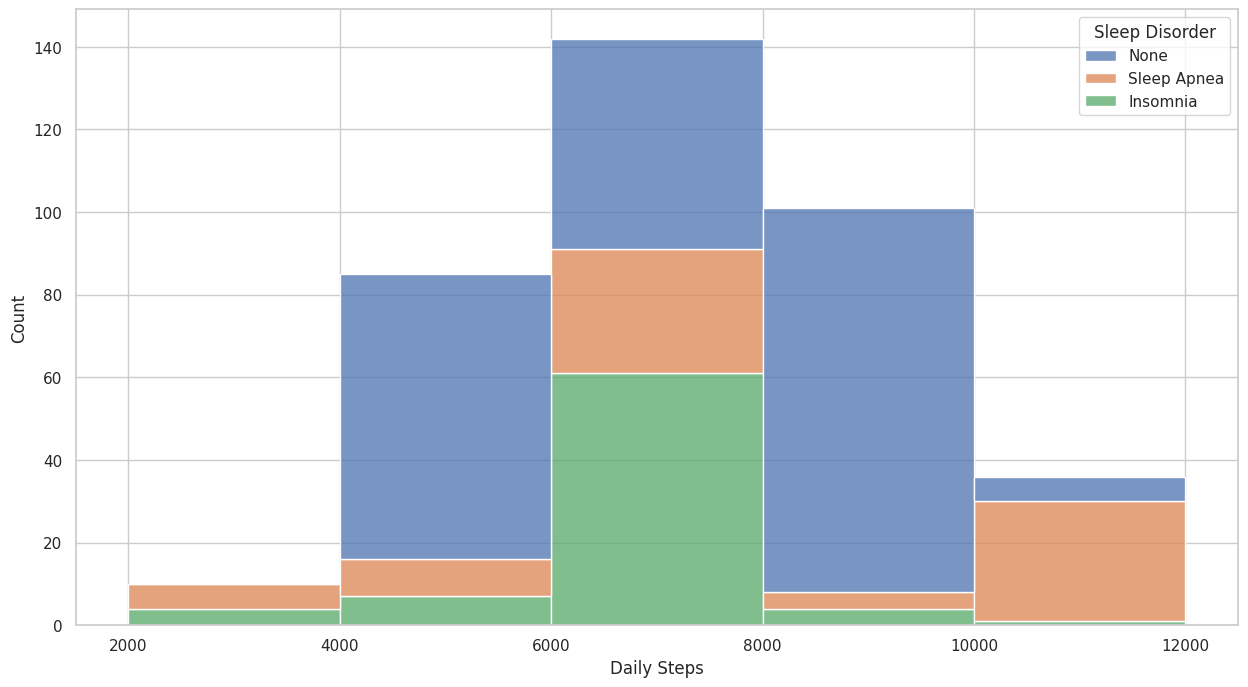

In [ ]:
plt.figure(figsize=(15,8))
sns.set_theme(style="whitegrid")
sns.histplot(data=df, x="Daily Steps", hue="Sleep Disorder", bins=[2000, 4000, 6000, 8000, 10000, 12000], multiple="stack")

<Axes: xlabel='Sleep Duration', ylabel='Count'>

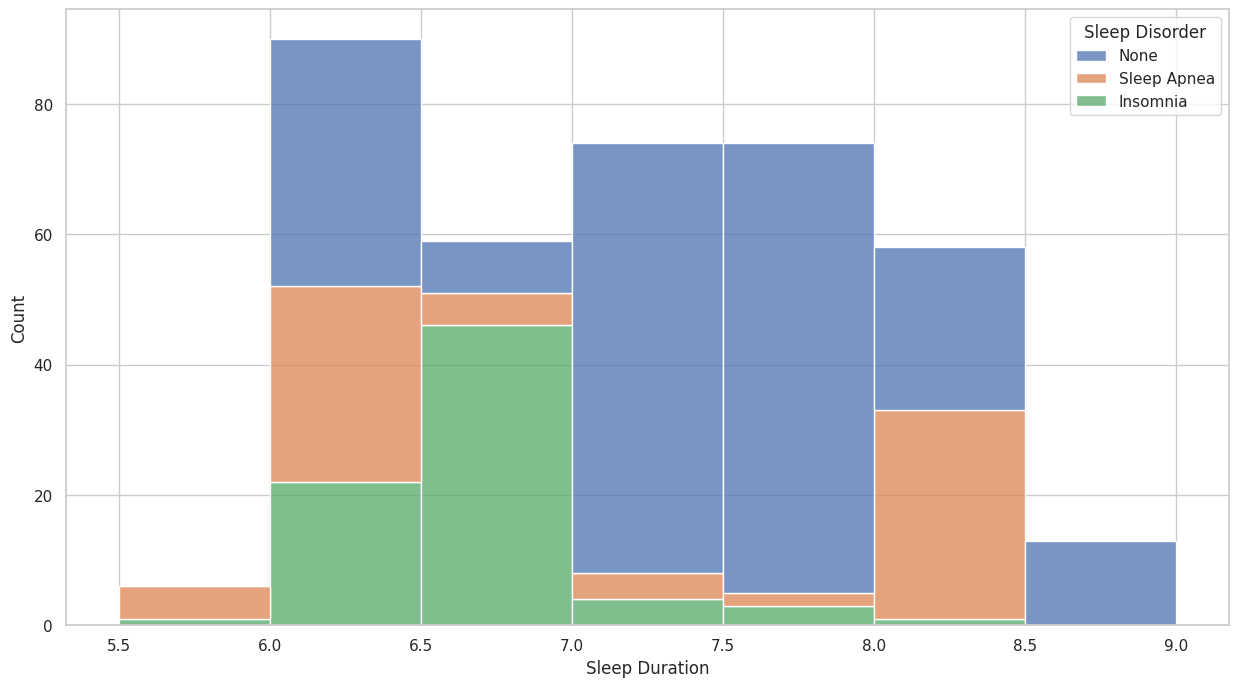

In [ ]:
plt.figure(figsize=(15,8))
sns.histplot(data=df, x="Sleep Duration", hue="Sleep Disorder", bins=[5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9], multiple="stack")

<Axes: xlabel='Age', ylabel='Count'>

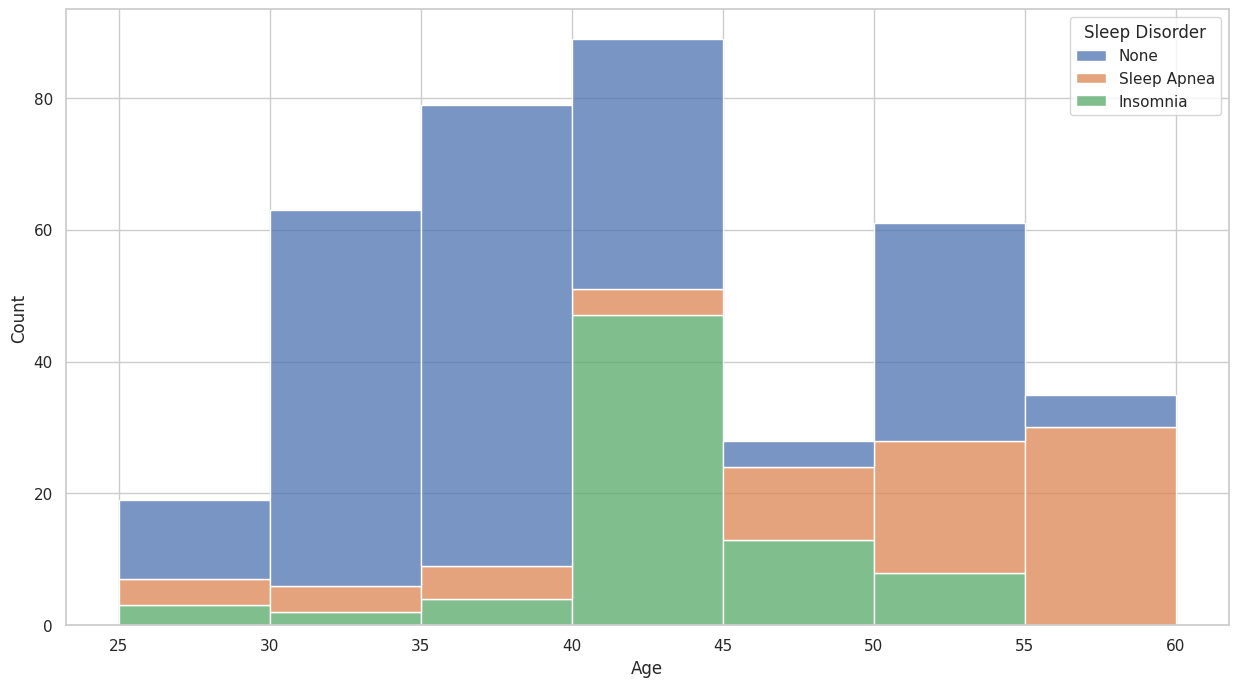

In [ ]:
plt.figure(figsize=(15,8))
sns.histplot(data=df, x="Age", hue="Sleep Disorder", bins=[25, 30, 35, 40, 45, 50, 55, 60], multiple="stack")

#Normalização

In [ ]:
# Normaliza o IMC e limpa a entrada.
# 1 é o valor máximo ótimo.
# https://en.wikipedia.org/wiki/Body_mass_index#BMI_prime_(exponent_of_2,_normalization_factor)
bmi_map = {
    "Normal": (0.74 + 0.99) / 2,
    "Normal Weight": (0.74 + 0.99) / 2,
    "Overweight": (1.00 + 1.19) / 2,
    "Obese": (1.39 + 1.20) / 2,
}

# Mapeamento genérico pq os modelos não são bons com strings.
gender_map = {
    "Male": 0,
    "Female": 1,
}


# https://en.wikipedia.org/wiki/Blood_pressure
def systolic_pressure_std(s):
    p = int(re.match("(\\d+)/(\\d+)", s).groups()[0])
    return (p - 120) / (180 - 120)


# https://en.wikipedia.org/wiki/Blood_pressure
def diastolic_pressure_std(s):
    p = int(re.match("(\\d+)/(\\d+)", s).groups()[1])
    return (p - 80) / (110 - 80)


# https://en.wikipedia.org/wiki/Heart_rate
def heart_rate_std(df):
    age = df["Age"]
    heart_rate = df["Heart Rate"]
    normal_min = 60
    normal_max = 220 - age
    return (heart_rate - normal_min) / (normal_max - normal_min)


# Seleção de atributos
# Padronizamos ou com os seletores acima, que são "justificados", ou com o
# minmax :^)
df_clean = pd.DataFrame(
    {
        # Person ID não entra, é um identificador
        "Gender": df["Gender"].map(gender_map),
        "Age": minmax_scale(df["Age"]),
        # Occupation não entra, é nominal e não deve ter tanta informação
        "Sleep Duration": df["Sleep Duration"] / 24,  # Para uma fração do dia
        "Quality of Sleep": minmax_scale(df["Quality of Sleep"]),
        "Physical Activity Level": minmax_scale(df["Physical Activity Level"]),
        "Stress Level": minmax_scale(df["Stress Level"]),
        "BMI Prime": df["BMI Category"].map(bmi_map),
        "Systolic Pressure": df["Blood Pressure"].map(systolic_pressure_std),
        "Diastolic Pressure": df["Blood Pressure"].map(diastolic_pressure_std),
        "Heart Rate": heart_rate_std(df),
        "Daily Steps": minmax_scale(df["Daily Steps"]),
        "Sleep Disorder": df["Sleep Disorder"],
    }
)

df_clean = df_clean.fillna("None")
df_clean

,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Prime,Systolic Pressure,Diastolic Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,0,0.00000,0.254167,0.4,0.20,0.6,1.095,0.100000,0.100000,0.127820,0.171429,None
1,0,0.03125,0.258333,0.4,0.50,1.0,0.865,0.083333,0.000000,0.113636,1.000000,None
2,0,0.03125,0.258333,0.4,0.50,1.0,0.865,0.083333,0.000000,0.113636,1.000000,None
3,0,0.03125,0.245833,0.0,0.00,1.0,1.295,0.333333,0.333333,0.189394,0.000000,Sleep Apnea
4,0,0.03125,0.245833,0.0,0.00,1.0,1.295,0.333333,0.333333,0.189394,0.000000,Sleep Apnea
...,...,...,...,...,...,...,...,...,...,...,...,...
369,1,1.00000,0.337500,1.0,0.75,0.0,1.095,0.333333,0.500000,0.079208,0.571429,Sleep Apnea
370,1,1.00000,0.333333,1.0,0.75,0.0,1.095,0.333333,0.500000,0.079208,0.571429,Sleep Apnea
371,1,1.00000,0.337500,1.0,0.75,0.0,1.095,0.333333,0.500000,0.079208,0.571429,Sleep Apnea
372,1,1.00000,0.337500,1.0,0.75,0.0,1.095,0.333333,0.500000,0.079208,0.571429,Sleep Apnea


<ipython-input-79-b96ab99ed903>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.zeros_like(df_clean.corr())
<ipython-input-79-b96ab99ed903>:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_clean.corr(method="spearman"), annot=True, mask=mask, linewidths=0.5, cmap='viridis')


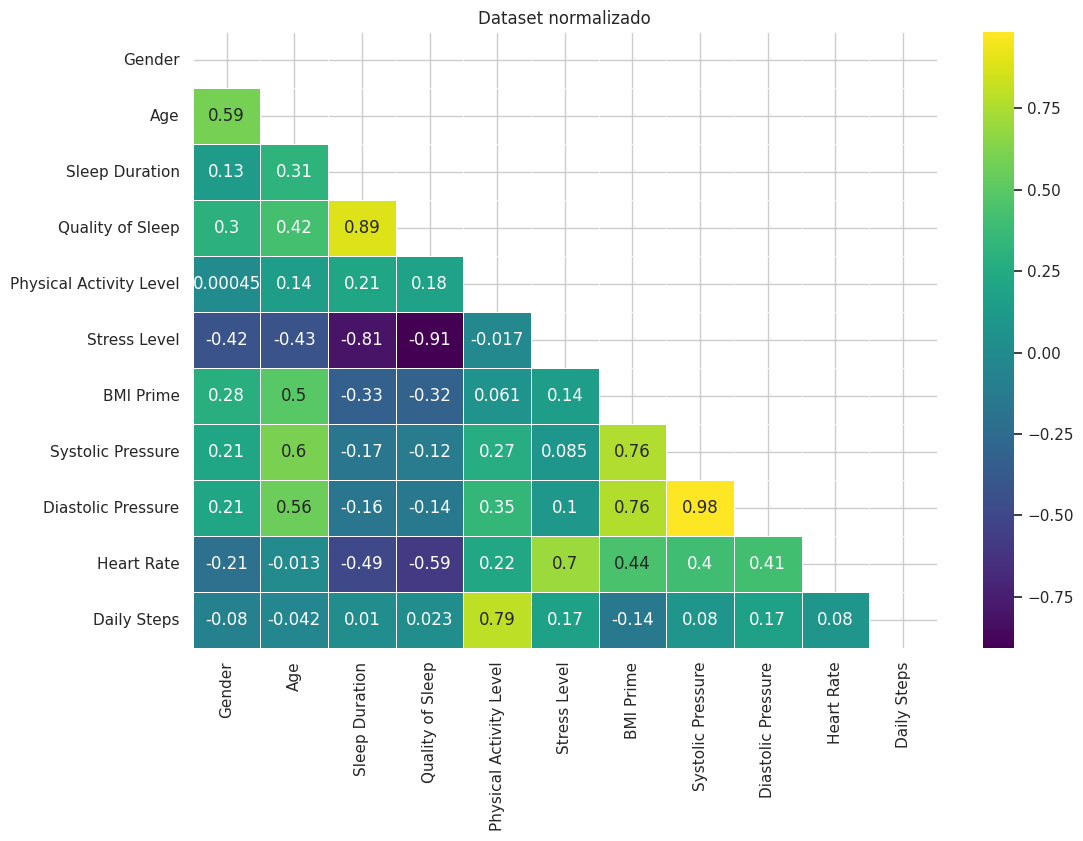

In [ ]:
#heatmap do dataset normalizado somente
mask = np.zeros_like(df_clean.corr())
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(12,8))
plt.title('Dataset normalizado')
sns.heatmap(df_clean.corr(method="spearman"), annot=True, mask=mask, linewidths=0.5, cmap='viridis')
plt.show()

# Modelos

In [ ]:
# Score
scoring = {
    "accuracy": make_scorer(accuracy_score)
}

In [ ]:
def ratear_modelo_parametrizado(df, intervalo, x, fn):
    lista = []
    for val in intervalo:
        cls = fn(val)
        scores = cross_validate(
            cls,
            df.drop("Sleep Disorder", axis="columns"),
            df["Sleep Disorder"],
            scoring=scoring,
        )
        lista.append({
            x: val,
            "test_accuracy": scores["test_accuracy"].mean(),
        })
    lista_df = pd.DataFrame.from_records(lista)
    plt.figure()
    sns.lineplot(data=lista_df, x=x, y="test_accuracy", label="Acurácia")

### Testando k-NN no dataset normalizado

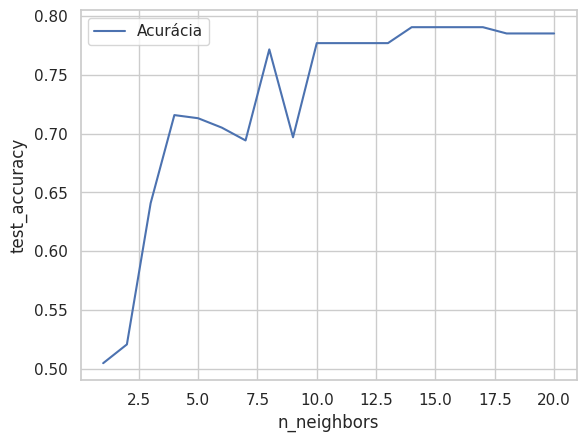

In [ ]:
ratear_modelo_parametrizado(
    df_clean,
    range(1, 21),
    "n_neighbors",
    lambda x: KNeighborsClassifier(n_neighbors=x)
)

###Testando Decision Tree no dataset normalizado

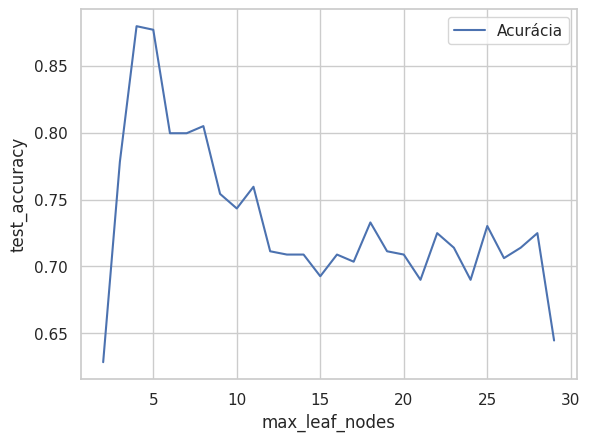

In [ ]:
ratear_modelo_parametrizado(
    df_clean,
    range(2, 30),
    "max_leaf_nodes",
    lambda x: DecisionTreeClassifier(max_leaf_nodes=x),
)

###Testando Naive Bayes no dataset normalizado

In [ ]:
# NB
cls = GaussianNB()
scores = cross_validate(
    cls,
    df_clean.drop("Sleep Disorder", axis="columns"),
    df_clean["Sleep Disorder"],
)
scores["test_score"].mean()

0.8741981981981983

##Criando amostra estratificada

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(test_size=0.26737967914438504) #esse número é usado para que a mostra tenha 100 objetos
for x,y in split.split(df_clean, df_clean['Sleep Disorder']):
  df_x = df_clean.iloc[x]
  df_y = df_clean.iloc[y]

In [ ]:
df_x.shape, df_y.shape

((274, 12), (100, 12))

In [ ]:
#amostragem estratificada -> exatamente a mesma proporção do dataset
df_y['Sleep Disorder'].value_counts()

None           58
Insomnia       21
Sleep Apnea    21
Name: Sleep Disorder, dtype: int64

In [ ]:
df_y.head()

,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Prime,Systolic Pressure,Diastolic Pressure,Heart Rate,Daily Steps,Sleep Disorder
299,1,0.75000,0.354167,1.0,0.00,0.0,0.865,0.083333,0.000000,0.045872,0.285714,None
27,0,0.09375,0.329167,0.6,0.75,0.6,0.865,0.000000,0.000000,0.076923,0.714286,None
181,0,0.46875,0.325000,0.8,1.00,0.4,0.865,0.166667,0.166667,0.084746,0.714286,None
37,0,0.12500,0.316667,0.6,0.75,0.6,0.865,0.000000,0.000000,0.077519,0.714286,None
0,0,0.00000,0.254167,0.4,0.20,0.6,1.095,0.100000,0.100000,0.127820,0.171429,None


<ipython-input-89-e57e586f25b7>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.zeros_like(df_y.corr())
<ipython-input-89-e57e586f25b7>:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_y.corr(method="spearman"), annot=True, mask=mask, linewidths=0.5, cmap='viridis')


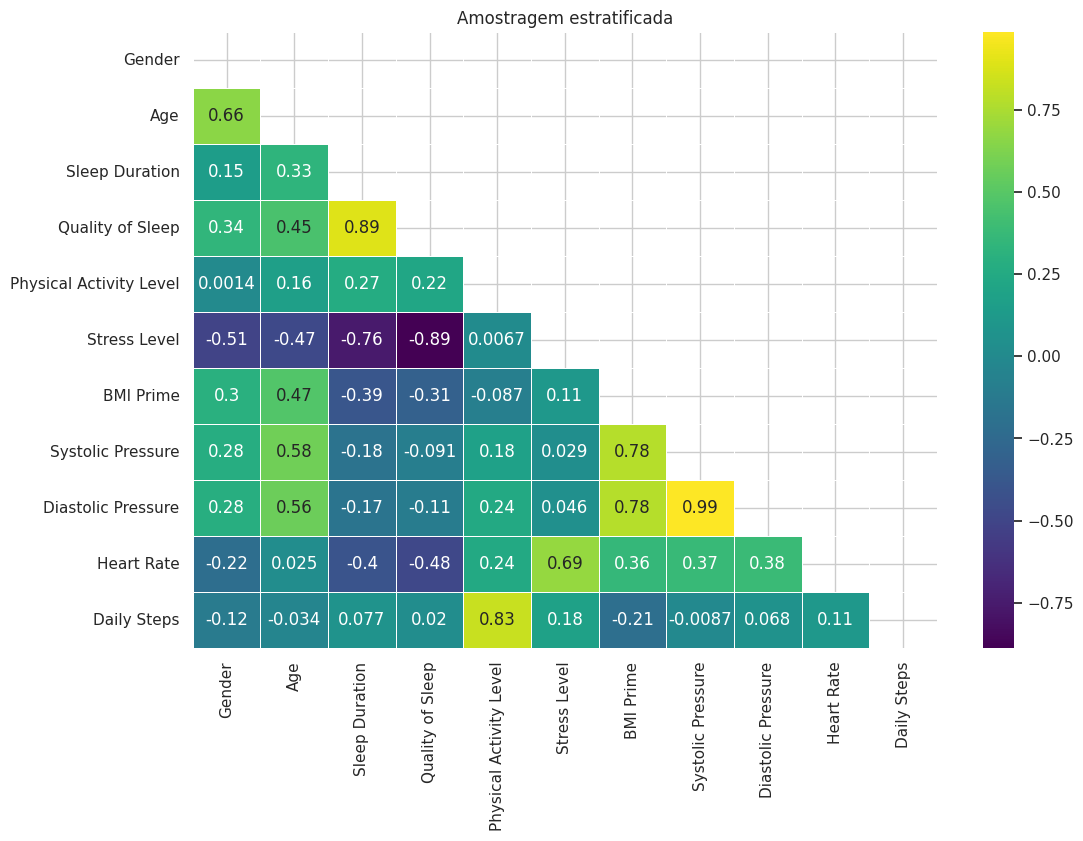

In [ ]:
#HEATMAP DEPOIS DA ESTRATIFICAÇÃO
mask = np.zeros_like(df_y.corr())
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(12,8))
plt.title('Amostragem estratificada')
sns.heatmap(df_y.corr(method="spearman"), annot=True, mask=mask, linewidths=0.5, cmap='viridis')
plt.show()

### Testando k-NN na amostra estratificada

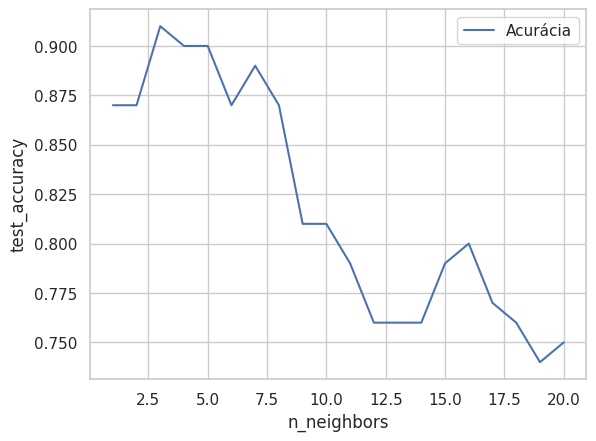

In [ ]:
ratear_modelo_parametrizado(
    df_y,
    range(1, 21),
    "n_neighbors",
    lambda x: KNeighborsClassifier(n_neighbors=x),
)

###Testando Decision Tree na amostra estratificada

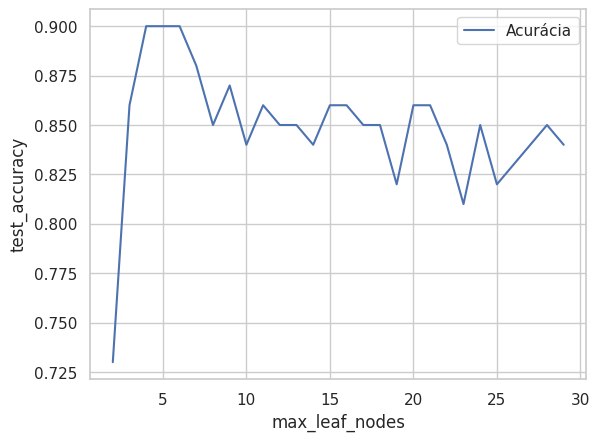

In [ ]:
ratear_modelo_parametrizado(
    df_y,
    range(2, 30),
    "max_leaf_nodes",
    lambda x: DecisionTreeClassifier(max_leaf_nodes=x),
)

###Testando Nive Bayes na amostra estratificada

In [ ]:
# NB
cls = GaussianNB()
scores = cross_validate(
    cls,
    df_y.drop("Sleep Disorder", axis="columns"),
    df_y["Sleep Disorder"],
)
scores["test_score"].mean()

0.9200000000000002

##Seleção de atributos do dataset normalizado
####Atriutos retirados: [ Stress Level, Daily Steps, Physical Activity Level, Diastolic Pressure, Gender ]


In [ ]:
df_clean_clean = df_clean.drop(columns="Gender", axis=1)
df_clean_clean = df_clean_clean.drop(columns="Stress Level", axis=1)
df_clean_clean = df_clean_clean.drop(columns="Age", axis=1)
df_clean_clean = df_clean_clean.drop(columns="Daily Steps", axis=1)
df_clean_clean = df_clean_clean.drop(columns="Physical Activity Level", axis=1)
df_clean_clean = df_clean_clean.drop(columns="Diastolic Pressure", axis=1)

In [ ]:
df_clean_clean

,Sleep Duration,Quality of Sleep,BMI Prime,Systolic Pressure,Heart Rate,Sleep Disorder
0,0.254167,0.4,1.095,0.100000,0.127820,None
1,0.258333,0.4,0.865,0.083333,0.113636,None
2,0.258333,0.4,0.865,0.083333,0.113636,None
3,0.245833,0.0,1.295,0.333333,0.189394,Sleep Apnea
4,0.245833,0.0,1.295,0.333333,0.189394,Sleep Apnea
...,...,...,...,...,...,...
369,0.337500,1.0,1.095,0.333333,0.079208,Sleep Apnea
370,0.333333,1.0,1.095,0.333333,0.079208,Sleep Apnea
371,0.337500,1.0,1.095,0.333333,0.079208,Sleep Apnea
372,0.337500,1.0,1.095,0.333333,0.079208,Sleep Apnea


<ipython-input-95-e7f5c86b888f>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.zeros_like(df_clean_clean.corr())
<ipython-input-95-e7f5c86b888f>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_clean_clean.corr(method="spearman"), annot=True, mask=mask, linewidths=0.5, cmap='viridis')


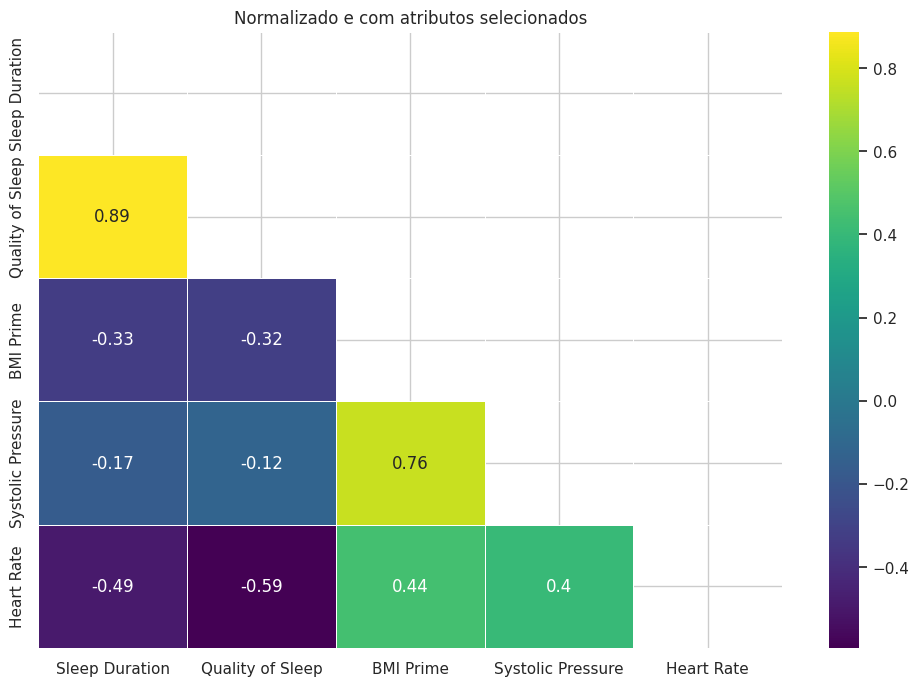

In [ ]:
mask = np.zeros_like(df_clean_clean.corr())
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(12,8))
plt.title('Normalizado e com atributos selecionados')
sns.heatmap(df_clean_clean.corr(method="spearman"), annot=True, mask=mask, linewidths=0.5, cmap='viridis')
plt.show()

###Testando k-NN depois da seleção de atributos

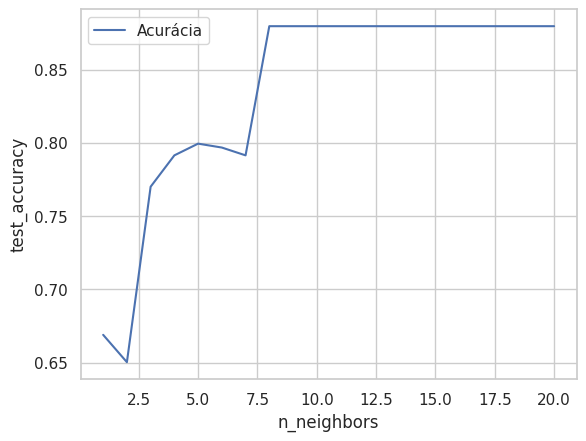

In [ ]:
ratear_modelo_parametrizado(
    df_clean_clean,
    range(1, 21),
    "n_neighbors",
    lambda x: KNeighborsClassifier(n_neighbors=x),
)

###Testando Decision Tree no dataset depois da seleção de atributos

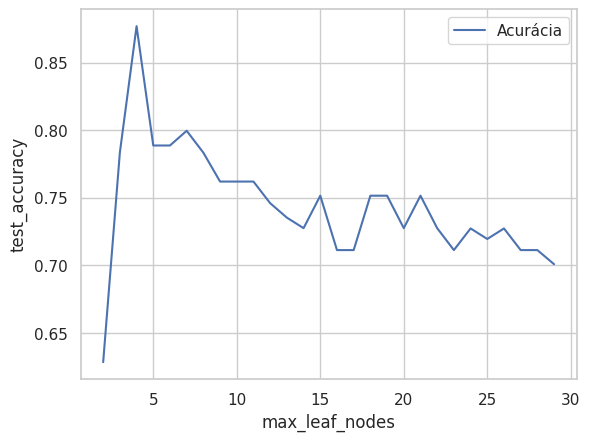

In [ ]:
ratear_modelo_parametrizado(
    df_clean_clean,
    range(2, 30),
    "max_leaf_nodes",
    lambda x: DecisionTreeClassifier(max_leaf_nodes=x),
)

###Testando Naive Bayes no dataset depois da seleção de atributos

In [ ]:
cls = GaussianNB()
scores = cross_validate(
    cls,
    df_clean_clean.drop("Sleep Disorder", axis="columns"),
    df_clean_clean["Sleep Disorder"],
)
scores["test_score"].mean()

0.8715315315315315

##Seleção de atributos da amostra estratificada
#### Os atributos retirados foram os mesmos

In [ ]:
df_y_clean = df_y.drop(columns="Gender", axis=1)
df_y_clean = df_y_clean.drop(columns="Age", axis=1)
#df_y_clean = df_y_clean.drop(columns="Stress Level", axis=1)
df_y_clean = df_y_clean.drop(columns="Daily Steps", axis=1)
df_y_clean = df_y_clean.drop(columns="Physical Activity Level", axis=1)
df_y_clean = df_y_clean.drop(columns="Diastolic Pressure", axis=1)

In [ ]:
df_y_clean

,Sleep Duration,Quality of Sleep,Stress Level,BMI Prime,Systolic Pressure,Heart Rate,Sleep Disorder
299,0.354167,1.0,0.0,0.865,0.083333,0.045872,None
27,0.329167,0.6,0.6,0.865,0.000000,0.076923,None
181,0.325000,0.8,0.4,0.865,0.166667,0.084746,None
37,0.316667,0.6,0.6,0.865,0.000000,0.077519,None
0,0.254167,0.4,0.6,1.095,0.100000,0.127820,None
...,...,...,...,...,...,...,...
288,0.250000,0.4,1.0,1.095,0.333333,0.136364,Sleep Apnea
248,0.266667,0.4,0.8,1.095,0.166667,0.103448,None
342,0.341667,1.0,0.0,0.865,-0.033333,0.048077,None
243,0.270833,0.6,0.2,1.095,0.250000,0.043103,Insomnia


<ipython-input-101-cb484274cbb4>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.zeros_like(df_y_clean.corr())
<ipython-input-101-cb484274cbb4>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_y_clean.corr(method="spearman"), annot=True, mask=mask, linewidths=0.5, cmap='viridis')


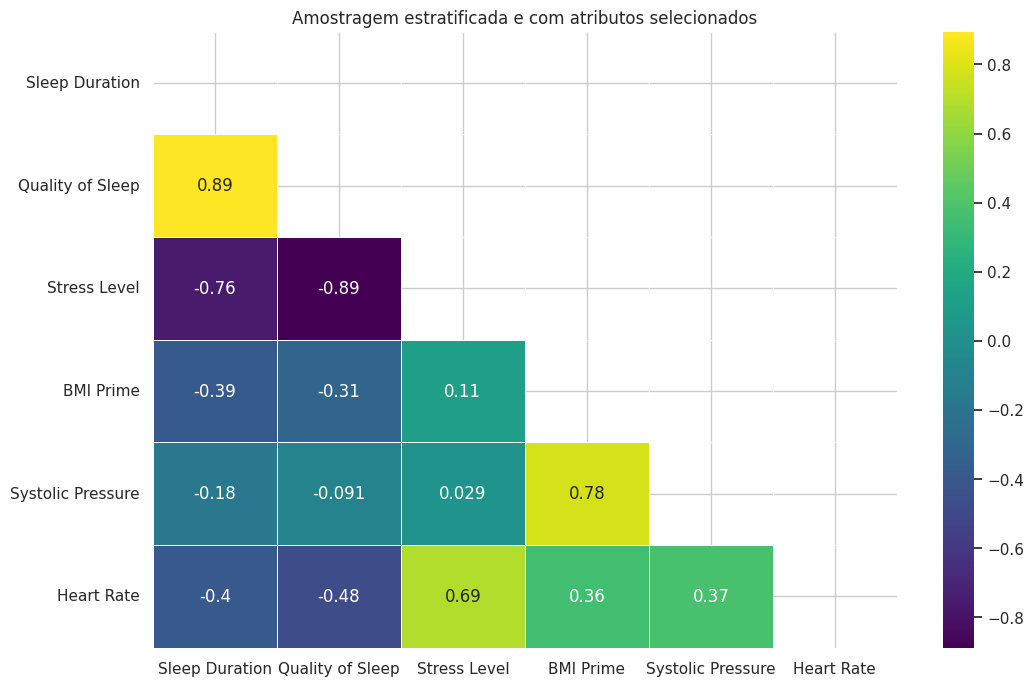

In [ ]:
mask = np.zeros_like(df_y_clean.corr())
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(12,8))
plt.title('Amostragem estratificada e com atributos selecionados')
sns.heatmap(df_y_clean.corr(method="spearman"), annot=True, mask=mask, linewidths=0.5, cmap='viridis')
plt.show()

###Testando o k-NN na amostra estratificada depois da seleção de atributos

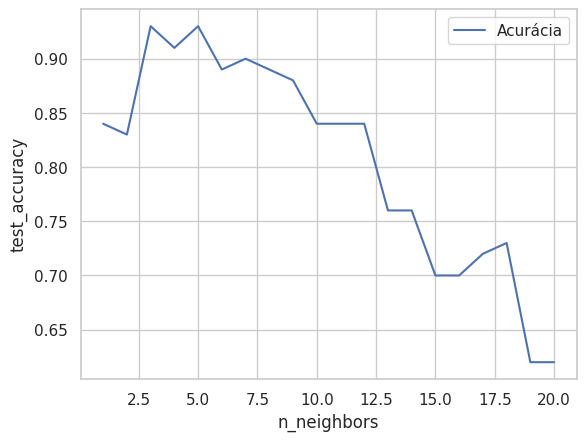

In [ ]:
ratear_modelo_parametrizado(
    df_y_clean,
    range(1, 21),
    "n_neighbors",
    lambda x: KNeighborsClassifier(n_neighbors=x),
)

Com o atributo "Age" -> 90.99% -> melhor até agora <br> Sem o atributo "Age" -> 89.99%

###Testando o Decision Tree na amostra estratificada depois da seleção de atributos

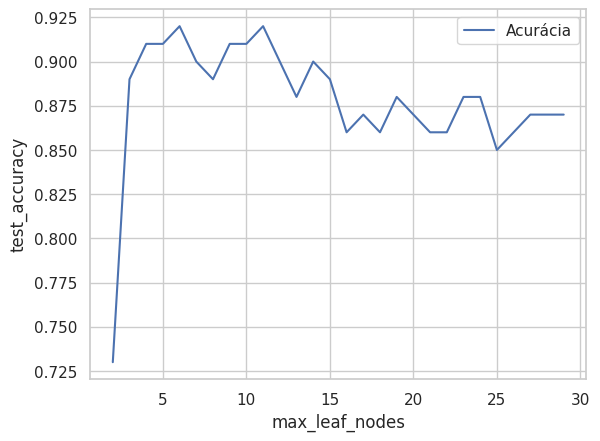

In [ ]:
ratear_modelo_parametrizado(
    df_y_clean,
    range(2, 30),
    "max_leaf_nodes",
    lambda x: DecisionTreeClassifier(max_leaf_nodes=x),
)

###Testando o Naive Bayes na amostra estratificada depois da seleção de atributos

In [ ]:
import plotly.graph_objs as go
import plotly.offline as py
eixo_x = ['KNN', 'Naive Bayes ', 'DT']

# Plotando o gráfico
n = go.Scatter(
    # Eixo x recebe o nome dos classificadores
    x = eixo_x,
    # Eixo y recebe os valores de acurácia
    y = [79.04,87.41,87.95],
    # Define o nome
    name = 'Dataset Normalizado',
    mode = 'lines+markers'
)

ae = go.Scatter(
    # Eixo x recebe o nome dos classificadores
    x = eixo_x,
    # Eixo y recebe os valores de acurácia
    y = [86.99,86,86],
    # Define o nome
    name = 'Amostra Estratificada',
    mode = 'lines+markers'
)

nr = go.Scatter(
    # Eixo x recebe o nome dos classificadores
    x = eixo_x,
    # Eixo y recebe os valores de acurácia
    y = [90.89,85.55,85.69],
    # Define o nome
    name = 'Dataset Normalizado Reduzido',
    mode = 'lines+markers'
)

aer = go.Scatter(
    # Eixo x recebe o nome dos classificadores
    x = eixo_x,
    # Eixo y recebe os valores de acurácia
    y = [88.99,89,86.99],
    # Define o nome
    name = 'Amostra Estratificada Reduzida',
    mode = 'lines+markers'
)

# Alterando configurações de Layout do Gráfico
layout = go.Layout(
    # Define Título
    title = 'Acurácias',
    # Define o nome do eixo X
    xaxis = {'title': 'Classificador'},
    # Define a cor da borda e contorno do gráfico
    paper_bgcolor='rgba(245, 246, 249, 1)',
    # Define a cor do fundo do gráfico
    plot_bgcolor='rgba(245, 246, 249, 1)'
)

data = [n, nr, ae, aer]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, image_height=5, image_width=10)